## Step 0: Imports

In [1]:
from gerrychain import (GeographicPartition, 
                        Partition, 
                        Graph, 
                        MarkovChain,
                        proposals, 
                        updaters, 
                        constraints, 
                        accept, 
                        Election)
from gerrychain.constraints import (single_flip_contiguous, 
                                    no_more_discontiguous,
                                    Validator)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from functools import partial

import networkx as nx
import maup
import geopandas

import gerrychain

In [2]:
pd.options.display.max_columns = None
%matplotlib inline

## Step 1: Setting up the initial districting plan

### Generating a graph to be partitioned

In [3]:
graph = Graph.from_file("VA_precincts_cleaned/va.shp")

/usr/local/anaconda3/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(892, 914), (893, 915), (887, 892), (887, 893)}
  overlaps


In [4]:
# Number of islands (isolated district)
len(graph.islands)

0

### Setting up election data

In [5]:
# Configure Election objects representing 
# some of the election data from shapefile
elections = [
    # Number of votes for 2018 senate candidate
    Election("SEN18", {"Democratic": "G18DSEN", 
                       "Republican": "G18RSEN",
                       "Other": "G18OSEN"}),
    # Number of votes for 2017 gubernatorial candidate
    Election("GOV17", {"Democratic": "G17DGOV", 
                       "Republican": "G17RGOV",
                       "Other": "G17OGOV"}),
    # Number of votes for 2016 presidential candidate
    Election("PRES16", {"Democratic": "G16DPRS", 
                        "Republican": "G16RPRS",
                        "Other": "G16OPRS"}),
    # Number of votes for 2016 US House candidate
    Election("HOR16", {"Democratic": "G16DHOR", 
                       "Republican": "G16RHOR",
                       "Other": "G16OHOR"}),
    # Voting age population
    Election("VPOP", {"Hispanic": "HVAP",
                      "White": "WVAP",
                      "Black": "BVAP",
                      "American Indian": "AMINVAP",
                      "Asian": "ASIANVAP",
                      "Native": "NHPIVAP",
                      "Other": "OTHERVAP"})
]

### Configuring our updaters

In [6]:
# Configure our updaters 
my_updaters = {
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population")
        "BVAP_population": Tally("BVAP", alias="BVAP_population")    

}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

SyntaxError: invalid syntax (<ipython-input-6-c829a1c77008>, line 5)

### Instantiating the partition

In [ ]:
# Instantiate the initial state of our Markov chain, 
# using 2012 enacted congressional district ID.
initial_partition = GeographicPartition(graph, 
                              assignment="CD_12", 
                              updaters=my_updaters)

In [ ]:
# Plotting districting plan
initial_partition.plot(figsize=(15,15), cmap="tab20")
plt.axis('off')
plt.show()

### The underlying graph

In [9]:
initial_partition.graph

<Graph [2439 nodes, 6859 edges]>

In [10]:
initial_partition.graph.nodes[0]

{'boundary_node': False,
 'area': 5223381.364718013,
 'precinct': 'Glenkirk',
 'locality': 'Prince William County',
 'loc_prec': 'Prince William County Glenkirk',
 'district': 'Congressional District 1',
 'G18DHOR': 980,
 'G18DSEN': 1044,
 'G18OHOR': 0,
 'G18OSEN': 32,
 'G18RHOR': 950,
 'G18RSEN': 856,
 'G17DGOV': 715,
 'G17DLTG': 701,
 'G17DATG': 698,
 'G17DHOD': 650,
 'G17RGOV': 744,
 'G17RLTG': 763,
 'G17RATG': 769,
 'G17RHOD': 804,
 'G17OHOD': 0,
 'G17OGOV': 13,
 'G16DPRS': 1083,
 'G16RPRS': 1155,
 'G16OPRS': 119,
 'G16DHOR': 920,
 'G16RHOR': 1320,
 'G16OHOR': 78,
 'TOTPOP': 3651.999991623403,
 'NH_WHITE': 2324.9999940296734,
 'NH_BLACK': 304.0000000887875,
 'NH_AMIN': 8.000000001742087,
 'NH_ASIAN': 591.999997592487,
 'NH_NHPI': 0.999999986279534,
 'NH_OTHER': 3.999999996110087,
 'NH_2MORE': 101.99999983433004,
 'HISP': 316.000000093993,
 'H_WHITE': 208.9999998809002,
 'H_BLACK': 8.000000085355632,
 'H_AMN': 6.311268e-08,
 'H_ASIAN': 1.0,
 'H_NHPI': 2.999999791550123,
 'H_OTHER': 

### The subgraphs of each part

In [13]:
for part, subgraph in initial_partition.subgraphs.items():
    number_of_edges = len(subgraph.edges)
    print(f"Part {part} has {number_of_edges} edges")

Part 1.0 has 480 edges
Part 2.0 has 406 edges
Part 3.0 has 484 edges
Part 4.0 has 610 edges
Part 5.0 has 778 edges
Part 6.0 has 580 edges
Part 7.0 has 580 edges
Part 8.0 has 424 edges
Part 9.0 has 866 edges
Part 10.0 has 488 edges
Part 11.0 has 354 edges


In [40]:
for part, subgraph in initial_partition.subgraphs.items():
    diameter = nx.diameter(subgraph)
    print(f"Part {part} has diameter {diameter}")

Part 1.0 has diameter 22
Part 2.0 has diameter 20
Part 3.0 has diameter 32
Part 4.0 has diameter 22
Part 5.0 has diameter 31
Part 6.0 has diameter 25
Part 7.0 has diameter 20
Part 8.0 has diameter 16
Part 9.0 has diameter 28
Part 10.0 has diameter 20
Part 11.0 has diameter 24


The diameter of a graph is the length of the longest shortest path between any two nodes in the graph.

### Outputs of updaters

In [41]:
len(initial_partition["cut_edges"])

809

In [42]:
proportion_of_cut_edges = \
    len(initial_partition.cut_edges) / len(initial_partition.graph.edges)
print("Proportion of edges that are cut:", proportion_of_cut_edges)

Proportion of edges that are cut: 0.11794722262720513


In [44]:
# Population in each part
initial_partition['population']

{1.0: 729829.999851378,
 2.0: 699644.0001874466,
 3.0: 763051.9993695281,
 4.0: 720016.0002511287,
 5.0: 727243.9999598453,
 6.0: 727366.0001690277,
 7.0: 726895.0001887272,
 8.0: 729484.9997716589,
 9.0: 727486.9996559347,
 10.0: 723848.0006304994,
 11.0: 726156.9995344761}

## Step 3: Setting up the Markov chain

### Proposal

In [18]:
# The ReCom proposal needs to know the ideal population 
# for the districts so that we can improve speed by 
# bailing early on unbalanced partitions.
ideal_population = \
    sum(initial_partition["population"].values()) / len(initial_partition)
print(ideal_population)

727365.8181426955


In [19]:
# Use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.05,
                   node_repeats=2)

### Constraints

In [20]:
# To keep districts about as compact as the original plan, 
# bound the number of cut edges at 2 times the number of cut edges 
# in the initial plan
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = \
    constraints.within_percent_of_ideal_population(initial_partition, 0.05)

In [147]:
def minBVAP(partition, pop_target, pop_key="BVAP_population", best=2):
    
    """Constraint that requires a minimum of BVAP on the X best districts.

    :param pop_target: minimum amount of population
    :param pop_key: race identifier (can be generated from a Tally)
    :param best: amount of districts that need to have at least the pop_target for the pop_key race.
    """
    max_BVAP = sorted(partition[pop_key].values())
    return pop_target < max_BVAP[-best]

minBVAP_constraint = partial(minBVAP,
                   pop_target=ideal_population*0.2
                 )

### Configuring the Markov chain

# TODO:
Now if the constraint is too high, we cannot start the algorithm.

We must find a way to preserve the max value of the old partition instead of taking it as a param

### Configuring the Markov chain

In [21]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=100
)

### Running the chain

In [22]:
# Run the chain, putting the sorted Asian voting age population percentages
# into a pandas DataFrame for analysis and plotting.
# This will take about 10 minutes.

asian_vpop = pd.DataFrame(
    sorted(partition["VPOP"].percents("Asian"))
    for partition in chain
)

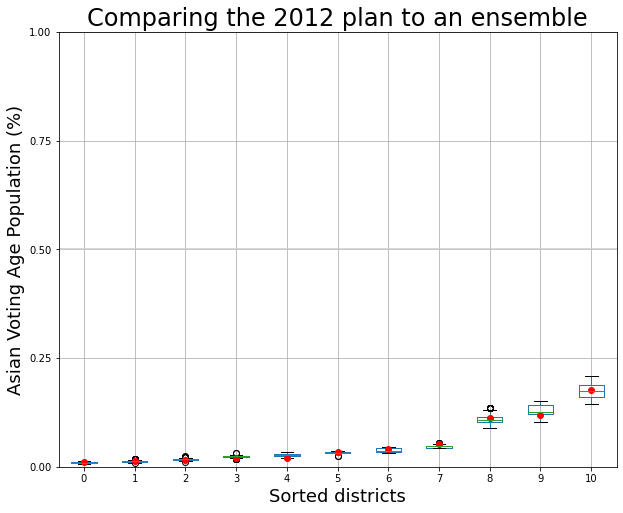

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
asian_vpop.boxplot(ax=ax, positions=range(len(asian_vpop.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(asian_vpop.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2012 plan to an ensemble", fontsize=24)
ax.set_ylabel("Asian Voting Age Population (%)", fontsize=18)
ax.set_xlabel("Sorted districts", fontsize=18)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

In [24]:
dem_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Democratic"))
    for partition in chain
)

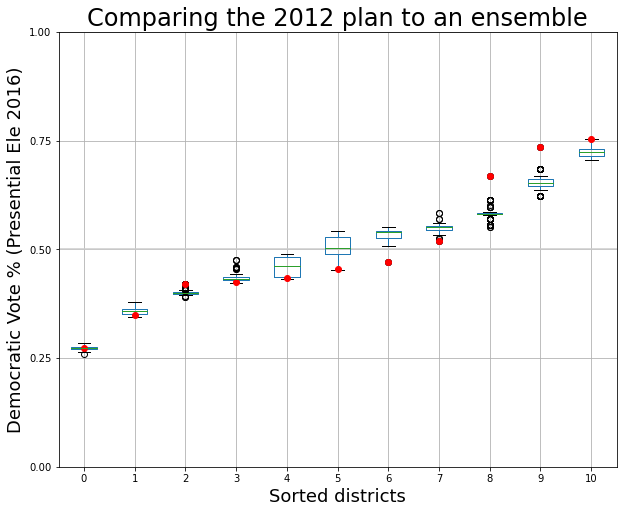

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
dem_pres.boxplot(ax=ax, positions=range(len(dem_pres.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(dem_pres.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2012 plan to an ensemble", fontsize=24)
ax.set_ylabel("Democratic Vote % (Presential Ele 2016)", fontsize=18)
ax.set_xlabel("Sorted districts", fontsize=18)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()